# **Progetto FESI**  - Baldini Filippo *S6393212* 
Tentativo di rimuovere **rumori e distorsioni** da tracce audio (*mono*) registrate tramite un giradischi soggetto a diversi tipi di interferenze (*Rega P1 - IO*)

---

In questo caso possiamo parlare di ***Rumore Addittivo***, il segnale dunque corrispondera a:

$$
\hat{S}(m) = S(m) + {N}(m)
$$
Dove:
- $\hat{S}(m)$ rappresenta il Segnale Rumoroso.
- $S(m)$ rappresenta il Segnale Pulito.
- ${N}(m)$ rappresenta il rumore addittivo.


In [29]:
# Import
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import IPython
import warnings

import librosa as lb # Libreria per sound-processing
import soundfile as sf # Libreria per esportare .wav

In [30]:
# Costanti
FS = 48000 # frequenza di campionamento dei file del dataSet
NOISE_SECTION = 5 # Ultimi secondi del brano = rumore puro (per dominio)
N_FFT = 2048 # Dimensione della finestra della STFT
HL = 512 # Overlap-Add, dopo aver analizzato i primi 2048 campioni non passo ai 2048 successivi 
         # ma ai 2048/4 successivi (512), necessario per non creare artefatti (sovrapposizione)
         
track_wav="../dataSet/input/temp.wav"
noise_wav="../dataSet/noise.wav"
OUTPUT_WIENER="../dataSet/output/outputW.wav"
OUTPUT_SOTTSPETTR="../dataSet/output/outputSS.wav"
OUTPUT_SOGLIATURA="../dataSet/output/outputS.wav"
OUTPUT_NORM_SS = "../dataSet/output/outputN_SS.wav"
OUTPUT_NORM_W = "../dataSet/output/outputN_W.wav"
OUTPUT_WAVELET = "../dataSet/output/output_WV.wav"

### Partiamo analizzando il *fenomeno rumoroso*
Otteniamo questo dato registrando l'output dell'amplificatore senza alcun brano in riproduzione (*rumore puro*)

### **FFT**

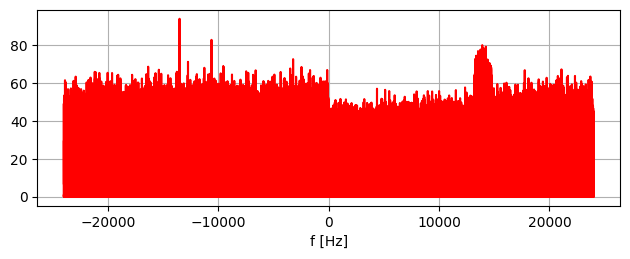

In [31]:
# Analizziamo il rumore
nfs, noise = wav.read(noise_wav) # creo l'array

N = len(noise) # Lunghezza dell'array noise (dei campioni)

# Proviamo a calcolare la trasformata di Fourier con la funzione np.fft.fft di numpy
nf = nfs/N * np.arange(N) # asse delle frequenze
FFT_noise = np.fft.fft(noise)/N # DFT dell'intero array
noise_freq = np.fft.fftfreq(N, 1/nfs) # Vettore delle frequenze

plt.subplot(2,1,2)
plt.plot(noise_freq,np.abs(FFT_noise),'-r',label="$X_f(f)$")
plt.xlabel('f [Hz]')
plt.tight_layout()
plt.grid()

L'approccio con una *singola Trasformata di Fourier* (**FFT**) sull'intero brano è inadatto, perché tratta il segnale come *statico*. Così facendo, si ottiene uno spettro che ha un'altissima risoluzione in frequenza, ma perdiamo completamente i riferimenti temporali. Si perde tutta l'informazione su quando una frequenza appare.

Dato che la musica è un segnale *non-stazionario* (che evolve continuamente), dobbiamo passare a una *Short-Time Fourier Transform* (**STFT**). Analizzando il segnale a fette cosi' mantenendo il legame frequenza-tempo.

La dimensione della finestra della **STFT**, `N_FFT` e' il parametro che definisce quanti campioni consideriamo per ogni trasformata. 
se tale finestra fosse molto ampia avremo una alta risoluzione in termini di frequenze campionate ma una pessima risoluzione temporale, vice versa per una finestra piu' corta.  

### **STFT**

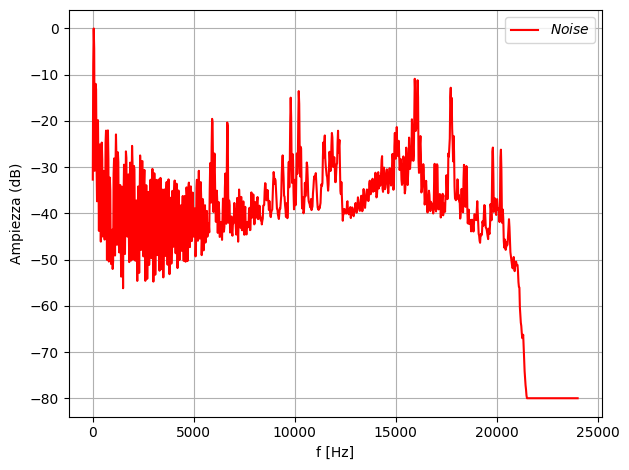

In [32]:
noise, sr = lb.load(noise_wav, sr=FS) # come per wav.read, ma crea un array di Float piuttosto che di Interi con Frequenza di Campionamento pari a FS = 48000Hz
STFT_noise = lb.stft(noise, n_fft = N_FFT, hop_length=HL) # eseguo la trasformata di Fourier (STFT) con le finestre prescelte

noise_mod = np.abs(STFT_noise) # considero il modulo della trasformata ossia una matrice bidimensionale (spettrogramma frequenza-tempo)
noise_profile = np.mean(noise_mod, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)
f = lb.fft_frequencies(sr=sr, n_fft=N_FFT) # asse delle frequenze da mettere a confronto con il profilo (lo definisco una sola volta)

noise_db = lb.amplitude_to_db(noise_profile, ref=np.max) # converte i float delle frequenze dell'array noise in decibel

plt.plot(f, noise_db,'-r',label="$Noise$")
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.legend()
plt.tight_layout()
plt.grid()

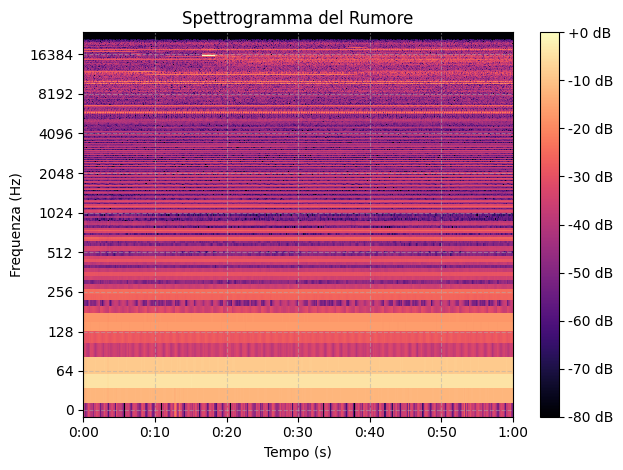

In [33]:
# Spettrogramma del Rumore:
noise_mod_db = lb.amplitude_to_db(noise_mod, ref=np.max)
lb.display.specshow(noise_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB') 
plt.title('Spettrogramma del Rumore')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza (Hz)')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Ora procediamo con l'analisi del *brano* (rumoroso)

In [34]:
# Riproduciamo il brano di partenza contenente il rumore
IPython.display.Audio(track_wav)

In [35]:
# Analizziamo il Brano
track, sr = lb.load(track_wav, sr=FS) # Questo comando carica il segnale e restituisce : segnale (array float), frequenza_campionamento
STFT_track = lb.stft(track, n_fft = N_FFT, hop_length=HL) # eseguo la trasformata di Fourier (STFT) con le finestre prescelte

track_mod = np.abs(STFT_track) # considero il modulo della trasformata (freq, time) 
track_profile = np.mean(track_mod, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

track_db = lb.amplitude_to_db(track_profile, ref=np.max) # converte i float delle frequenze dell'array noise in decibel

/var/folders/jg/37l_l3y5767gf664zsdvms5r0000gn/T/ipykernel_7814/679918296.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  track, sr = lb.load(track_wav, sr=FS) # Questo comando carica il segnale e restituisce : segnale (array float), frequenza_campionamento
/Users/filippob04/venvs/py313/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


EOFError: 

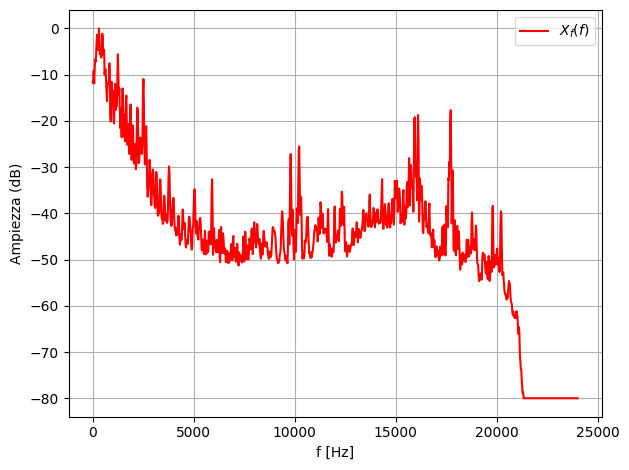

In [ ]:
plt.plot(f, track_db,'-r',label="$X_f(f)$")
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.legend()
plt.tight_layout()
plt.grid()

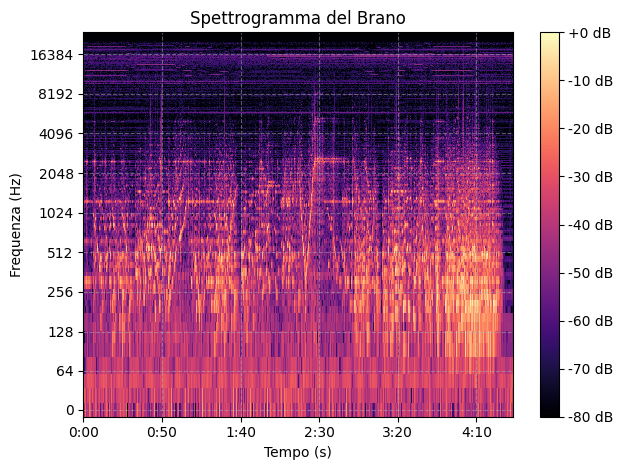

In [ ]:
# Spettrogramma del Brano:
track_mod_db = lb.amplitude_to_db(track_mod, ref=np.max) # considero la trasformazione in decibel della matrice 2D che definisce lo spettrogramma
lb.display.specshow(track_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB') 
plt.title('Spettrogramma del Brano')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza (Hz)')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### **Denoising**
Possiamo scegliere fra due Approcci, o utilizziamo il rumore in se come riferimento, rischiando di avere registrazioni effettuate in condizioni diverse oppure, per assicurarci che **Rumore** e **Brano** siano stati registrati con gli stessi *parametri*, aggiungiamo la condizione che i file in input *terminino con dei secondi di rumore puro* cosi' saremo in grado di estrapolare tale sezione assicurandoci cosi' di avere la stessa base di partenza (determinata dall'amplificatore (*volume*))

In [ ]:
# Estraiamo il rumore dagli ultimi NOISE_SECTION secondi del brano
noise_samples = int(NOISE_SECTION * sr) # numero di campioni (secondi * frequenza)

# Dividiamo il brano in due: Musica e Rumore Finale
noise_part = track[-noise_samples:]
music_part = track[:-noise_samples]

In [ ]:
# Eseguiamo STFT del brano e del Rumore
STFT_track = lb.stft(music_part, n_fft=N_FFT, hop_length=HL)
STFT_noise = lb.stft(noise_part, n_fft = N_FFT, hop_length=HL) 

track_mod = np.abs(STFT_track) # calcoliamo il modulo del brano (matrice 2D tempo-frequenza)
noise_mod = np.abs(STFT_noise) # idem per rumore

track_profile = np.mean(track_mod, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)
noise_profile = np.percentile(noise_mod, 75, axis=1) # considero i valori superiori all'x% dei casi, piu' aggressiva rispetto ad una media matematica 

ref_value = max(np.max(track_profile), np.max(noise_profile)) # valore per normalizzare le due tracce 

noise_db = lb.amplitude_to_db(noise_profile, ref=ref_value) # converte le ampiezze dell'array in decibel
track_db = lb.amplitude_to_db(track_profile, ref=ref_value) # idem per traccia

### **SNR**, Signal to Noise Ratio
Metrica fondamentale per quantificare l'impatto che il rumore ha sul segnale in analisi, ha la forma (nel caso dei decibel dB):
$$
SNR_{dB} = 10log_{10}\left(\frac{P_{Signal}}{P_{Noise}}\right)
$$
Dove:
- $SNR_{dB}$ e' il rapporto Segnale-Rumore relativo ai decibel
- $P_{Signal}$ e' la potenza (modulo quadro) del segnale pulito
- $P_{Noise}$ e' la potenza del Rumore Addittivo


In [ ]:
# Calcolo SNR del brano originale
noisePow = np.mean(noise_part ** 2)
noisySignalPow = np.mean(music_part** 2)

signalPow = np.maximum(noisySignalPow - noisePow, 1e-10)

snr = 10 * np.log10(signalPow / (noisePow + 1e-10))
print(f"-> SNR Originale: {snr:.2f} dB")

-> SNR Originale: 18.38 dB


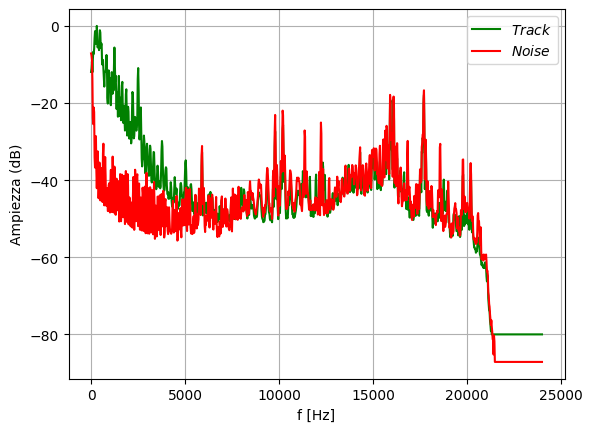

In [ ]:
plt.plot(f, track_db,'-g', label="$Track$")
plt.plot(f, noise_db,'-r', label="$Noise$")

plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')

plt.legend(loc="upper right")
plt.grid()

con questa vista possiamo notare un problema fondamentale, *il rumore vive nello stesso range di frequenze del brano* dunque l'applicazione di un semplice *filtro di sogliatura* rimuoverebbe gran parte dei dettagli del brano rendendolo irriconoscibile.

### **Sogliatura**

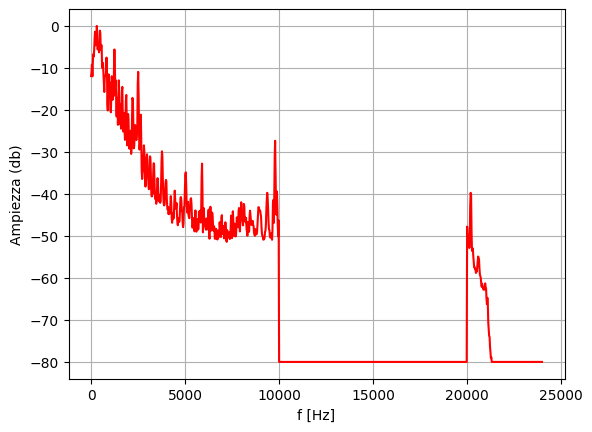

In [ ]:
# Esempio di Sogliatura
thresh_h = 20000
thresh_l = 10000

# find all the indices corresponding to frequencies greather than a threshold 
idx = np.argwhere((np.abs(f) < thresh_h) & (np.abs(f) > thresh_l))
STFT_cut=np.copy(STFT_track)
STFT_cut[idx, :] = 0 # imposta l'ampiezza dei valori a zero

track_filt = np.mean(np.abs(STFT_cut), axis=1)
track_filt_db = lb.amplitude_to_db(track_filt, ref=np.max)

track_clean_filtered = lb.istft(STFT_cut, hop_length=HL) # Torniamo nel dominio del tempo
# Output
sf.write(OUTPUT_SOGLIATURA, track_clean_filtered, sr, subtype='PCM_24')

plt.plot(f, track_filt_db, '-r', label=f"Spettro Filtrato (- ({thresh_l} < {thresh_h}) Hz)")
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (db)')

plt.grid()

Evidentemente quindi non e' possibile eseguire una semplice sogliatura per rimuovere la parte rumorosa.

### **Sottrazione Spettrale**
Procediamo con un primo tentativo di riduzione del Rumore tramite l'operazione di **Sottrazione Spettrale**, ossia tentiamo di *sottrarre* (operando su matrici 2D (*tempo-frequenza*)) una *stima dello spettro medio del rumore* (`profile_expanded`) dallo *spettro del segnale originale* (`track_mod`) (rumoroso). 

$$
|\hat{S}(m, f)| = max(|X(m,f)| - |\hat{N}(m, f)|, 0 )
$$
Dove:
- $|\hat{S}(m, f)|$ rappresenta il modulo del segnale pulito stimato.
- $|X(m,f)|$ rappresenta il modulo del segnale rumoroso iniziale
- $|\hat{N}(m, f)|$ rappresenta il modulo dello spettro medio del rumore.

Il metodo si basa sull'assunzione che il rumore sia una *componente* **addittiva** e **stazionaria** (o che vari molto lentamente) ovvero che il suo spettro medio non cambi significativamente tra i diversi *campioni* della **STFT**. Il profilo del rumore viene stimato analizzando i momenti di "silenzio" (in cui è presente solo il rumore puro), isolati precedentemente. È importante notare che, *matematicamente*, la sottrazione potrebbe generare valori negativi (ad esempio nelle zone di silenzio o dove *noise > segnale*). Poiché un'energia negativa non ha significato fisico, in tali casi il risultato viene forzato a zero (**clipping**)

Infine, per la ricostruzione del segnale nel dominio del tempo, la stima dello spettro di *magnitudine* pulita (`mod_clean`) viene combinata con la **fase del segnale** rumoroso originale e trasformata tramite la *trasformata inversa di Fourier* (**ISTFT**) 

[SPECTRAL SUBTRACTION - PDF](../PDF/SS.pdf)

In [ ]:
# Procediamo con un primo tentativo di riduzione del Rumore
profile_expanded = noise_profile[:, np.newaxis] # Passiamo da un vettore 1D (medie ampiezze rumorose) ad una versione 2D (con le dimensioni di track_mod)

# Sottrazione Spettrale: sottraiamo la stima del rumore e imponiamo valori non negativi
mod_clean = np.maximum(track_mod - profile_expanded, 0) # Dove era presente noise > track il rumore viene ridotto (0 indica il floor, x < 0 = 0)

track_phase = np.angle(STFT_track) # Otteniamo la fase (theta) del brano
STFT_clean = mod_clean * np.exp(1j * track_phase) # Eulero e^jθ

track_clean = lb.istft(STFT_clean, hop_length=HL) # Torniamo nel dominio del tempo con la trasformata inversa

# Output
sf.write(OUTPUT_SOTTSPETTR, track_clean, sr, subtype='PCM_24')

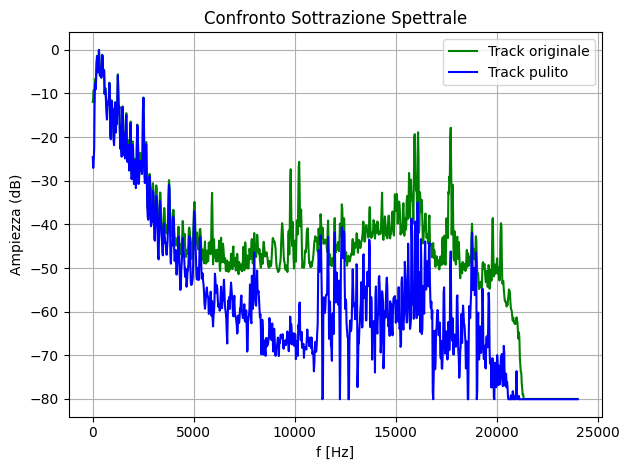

In [ ]:
# Analisi spettrale del segnale pulito
clean_profile = np.mean(mod_clean, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

f = lb.fft_frequencies(sr=sr, n_fft=N_FFT)
ref_value = max(np.max(track_profile), np.max(clean_profile)) # valore per normalizzare le due tracce

ss_db = lb.amplitude_to_db(clean_profile, ref=ref_value)

# Plot confronto
plt.figure()
plt.plot(f, track_db, '-g', label='Track originale')
plt.plot(f, ss_db, '-b', label='Track pulito')
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.title('Confronto Sottrazione Spettrale')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Notiamo come il segnale pulito pressocche' segua quello originale, con la piu' grande differenza osservabile fra i *15000Hz - 18500Hz* dove risiedeva anche la gran parte del rumore udibile

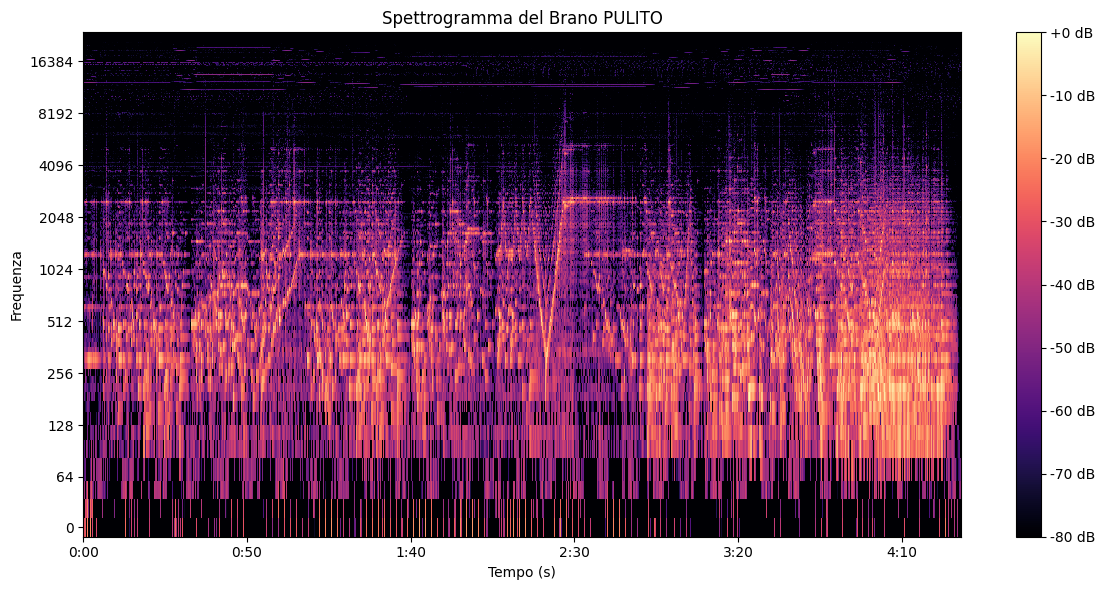

In [ ]:
clean_mod_db = lb.amplitude_to_db(mod_clean, ref=np.max)
plt.figure(figsize=(12, 6))

lb.display.specshow(clean_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB')
plt.title('Spettrogramma del Brano PULITO')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()

In [ ]:
# SNR - Sottrazione Spettrale
track_ss, _ = lb.load(OUTPUT_SOTTSPETTR, sr=FS)
noise_samples_bis = int(2 * sr) # numero di campioni (secondi * frequenza)

# Separiamo usando sempre 3 secondi
noise_part_ss = track_ss[-noise_samples_bis:]
signal_part_ss = track_ss[:-noise_samples_bis:]

# Calcolo Potenze
p_noise_ss = np.mean(noise_part_ss ** 2)
p_signal_noisy_ss = np.mean(signal_part_ss ** 2)

# Stima Segnale Puro
p_signal_pure_ss = np.maximum(p_signal_noisy_ss - p_noise_ss, 1e-10)

# Calcolo dB
snr_ss = 10 * np.log10(p_signal_pure_ss / (p_noise_ss + 1e-10))
print(f"-> SNR Sottrazione Spettrale: {snr_ss:.2f} dB")
print(f"   Guadagno vs Originale: +{snr_ss - snr:.2f} dB")

-> SNR Sottrazione Spettrale: 22.07 dB
   Guadagno vs Originale: +3.70 dB


### **Normalizzazione**
Ascoltando il brano o analizzando il grafico ci rendiamo rapidamente conto che il volume originale risulta ribassato (banalmente si tratta di una sottrazione alla fine dei conti) dunque dobbiamo sottoporlo ad un processo di **normalizzazione**.
Tale processo consiste nel trovare il sample massimo, portarlo a +- 1 dB ed aggiustare gli altri campioni di conseguenza

In [ ]:
# Normalizzazione
peak = np.max(np.abs(track_clean)) # eseguo il valore assoluto del segnale pulito per trovare il valore massimo (nel dominio del tempo)
target_amp = 0.98

gain = target_amp/peak # calcolo il fattore di guadagno ossia di quanto devo incrementare la traccia (prodotto scalare)
track_norm = track_clean * gain

sf.write(OUTPUT_NORM_SS, track_norm, sr, subtype='PCM_24') # output

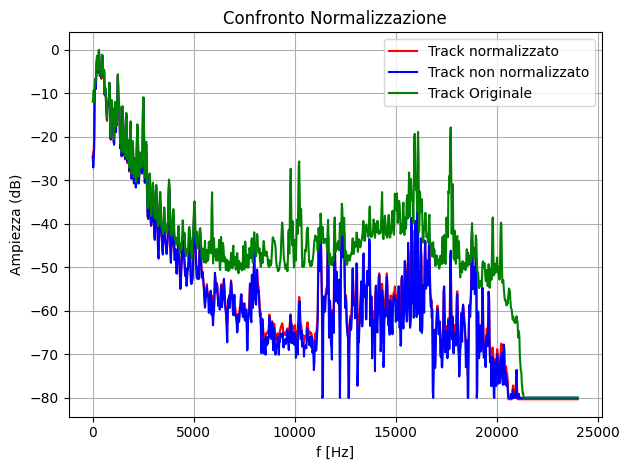

In [ ]:
STFT_norm = lb.stft(track_norm, n_fft = N_FFT, hop_length=HL) # andiamo nel dominio delel frequenze
mod_norm = np.abs(STFT_norm) # calcoliamo il modulo (tempo-frequenza)
norm_profile = np.mean(mod_norm, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

ref_value = max(np.max(norm_profile), np.max(track_profile), np.max(clean_profile)) # valore per normalizzare le due tracce
norm_db = lb.amplitude_to_db(norm_profile, ref=ref_value)

# Plot confronto 
plt.figure()
plt.plot(f, norm_db, '-r', label='Track normalizzato')
plt.plot(f, ss_db, '-b', label='Track non normalizzato')
plt.plot(f, track_db, '-g', label='Track Originale')
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.title('Confronto Normalizzazione')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Ascoltando i risultati ottenuti e' evidente la presenza di **rumore residuo** e come descritto nel documento allegato (*III.A*), la sottrazione spettrale induce ***musical noise*** nel momento in cui troviamo sezioni anomale, con solo rumore, rumore stimato < rumore effettivo o vice versa. Tale ***musical noise*** e' quel rumore "acquoso" che rende suoni distorti e poco distinguibili dovuto all'applicazione di questo filtro.

[Combined Spectral Subtraction and Wiener Filter Methods in
Wavelet Domain for Noise Reduction - PDF](../PDF/SS&WF.pdf)

Dunque, seguendo il *paper* sopra citato, proviamo ad implementare un *filtro di Wiener*.

### **Filtro di Wiener**

Il ***filtro di Wiener*** e' una operazione che si basa su principi statistico-matematici, ha come obiettivo quello di trovare un filtro che renda la differenza (**errore quadratico medio**) tra il *segnale pulito ideale* e la nostra *stima* il più piccola possibile.
In parole povere, cerca il compromesso matematicamente perfetto per salvare più musica possibile rimuovendo più rumore possibile.

Si basa su una assunzione fondamentale, che il *rumore* e il *segnale* siano **scorrelati**, ossia che sia un **fenomeno addittivo** (come nel nostro caso).

Matematicamente, il *guadagno del filtro G(m,f)* per ogni *frequenza f* e *istante temporale m* è definito dalla seguente formula:

$$
G(m, f) = \frac{|\hat{S}(m, f)|^2}{|S(m, f)|^2 + |N(m, f)|^2}
$$
Dove:
- $|\hat{S}(m, f)|^2$ rappresenta la potenza (modulo al quadrato) del segnale pulito stimato.
- $|N(m,f)|^2$ rappresenta la potenza dello spettro del rumore.
- Il denominatore $|S(m, f)|^2 + |N(m, f)|^2$ rappresenta l'energia totale del segnale rumoroso osservato.

anche sottoponendo il segnale rumoroso a questo filtro, è possibile ottenere residui di ***musical noise***. Tuttavia, rispetto alla ***sottrazione spettrale***, questo fenomeno si presenta in **grado minore**, risultando talvolta sopprimibile o mascherabile con tecniche di smoothing temporale.

In [ ]:
# Filtro di Wiener
N_AMP = 1 # Amplifica il rumore per essere piu' aggressivo
MIN_DB = 0.01 # Soglia minima 

track_energy = track_mod **2 # Sarebbe il denominatore (Segnale Totale)
noise_energy = (profile_expanded * N_AMP) **2  # Potenza del rumore stimato (dagli ultimi secondi del brano)

cleanSig_energy = np.maximum(track_energy - noise_energy, 0) # (S(m,f))

mask = cleanSig_energy/(track_energy + 1e-10) # G(m,f), aggiungo un valore trascurabile per evitare situazioni scomode (0)
mask = np.maximum(mask, MIN_DB) # Se trovo porzioni di solo rumore (= 0) le imposto ad un minimo 1%

mod_clean = track_mod * mask # Applico il filtro (dominio delle frequenze, moltiplicazione)
STFT_clean = mod_clean * np.exp(1j * track_phase) # Eulero e^jθ

track_clean = lb.istft(STFT_clean, hop_length=HL) # Torniamo nel dominio del tempo con la trasformata inversa

# Output
sf.write(OUTPUT_WIENER, track_clean, sr, subtype='PCM_24')

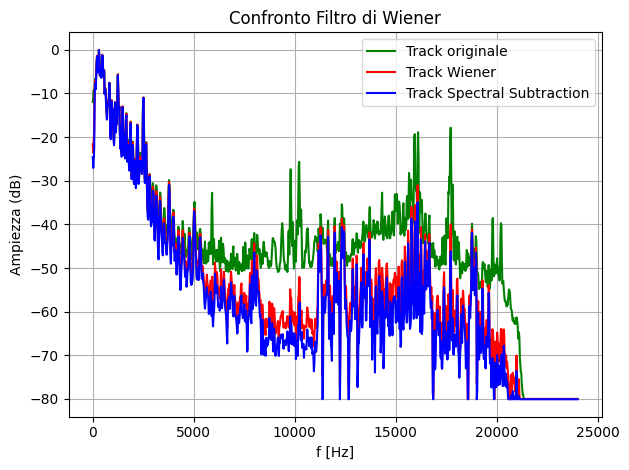

In [ ]:
# Analisi del segnale pulito in seguito all'applicazione del filtro di Wiener
clean_profile = np.mean(mod_clean, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

f = lb.fft_frequencies(sr=sr, n_fft=N_FFT)
ref_value = max(np.max(track_profile), np.max(clean_profile)) # valore per normalizzare le due tracce

w_db = lb.amplitude_to_db(clean_profile, ref=ref_value)

# Plot confronto
plt.figure()
plt.plot(f, track_db, '-g', label='Track originale')
plt.plot(f, w_db, '-r', label='Track Wiener')
plt.plot(f, ss_db, '-b', label='Track Spectral Subtraction')
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.title('Confronto Filtro di Wiener')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Dal grafico si evince che abbiamo perso meno "*informazione musicale*" rispetto che ad una applicazione di un filtro piu' severo.

Ad Esempio nella sezione piu' rumorosa sulle alte frequenze comprese fra *15000Hz - 18500Hz*, il cambiamento fra il rapporto del **filtro di Wiener** e `np.maximum(track_mod - profile_expanded, 0)` della **Sottrazione Spettrale** e' evidente.

Il rumore di fondo, ***musical_noise*** dovuto al taglio netto della **Sottrazione Spettrale** risulta eliminato all'udito (meno ovattato e alcune componenti risultano piu' distinguibili) tuttavia permane un rumore di sottofondo.

Note: Esplorando diversi valori di `N_AMP` e `MIN_DB` possiamo rendere piu' o meno aggressivo il filtro

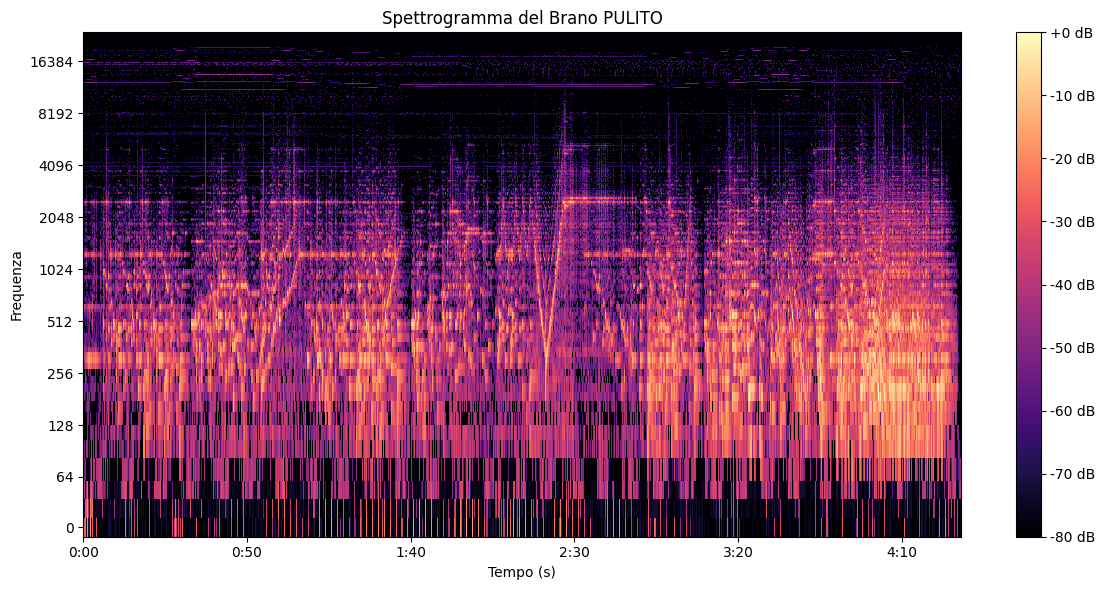

In [ ]:
clean_mod_db = lb.amplitude_to_db(mod_clean, ref=np.max)
plt.figure(figsize=(12, 6))

lb.display.specshow(clean_mod_db, sr=sr, hop_length=HL, x_axis='time', y_axis='log')

plt.colorbar(format='%+2.0f dB')
plt.title('Spettrogramma del Brano PULITO')
plt.xlabel('Tempo (s)')
plt.ylabel('Frequenza')
plt.tight_layout()
plt.show()

In [ ]:
# SNR - Filtro di Wiener
track_wf, _ = lb.load(OUTPUT_WIENER, sr=FS)
noise_samples_bis = int(2 * sr) # numero di campioni (secondi * frequenza)

# Separiamo usando sempre 3 secondi
noise_part_wf = track_wf[-noise_samples_bis:]
signal_part_wf = track_wf[:-noise_samples_bis:]

# Calcolo Potenze
p_noise_wf = np.mean(noise_part_wf ** 2)
p_signal_noisy_wf = np.mean(signal_part_wf ** 2)

# Stima Segnale Puro
p_signal_pure_wf = np.maximum(p_signal_noisy_wf - p_noise_wf, 1e-10)

# Calcolo dB
snr_wf = 10 * np.log10(p_signal_pure_wf / (p_noise_wf + 1e-10))
print(f"-> SNR Filtro di Wiener: {snr_wf:.2f} dB")
print(f"-> SNR Sottrazione Spettrale: {snr_ss:.2f} dB")
print(f"   Filtro di Wiener vs Originale: +{snr_wf - snr:.2f} dB")
print(f"   Filtro di Wiener vs Sottrazione Spettrale: {snr_wf - snr_ss:.2f} dB")

-> SNR Filtro di Wiener: 20.78 dB
-> SNR Sottrazione Spettrale: 22.07 dB
   Filtro di Wiener vs Originale: +2.40 dB
   Filtro di Wiener vs Sottrazione Spettrale: -1.30 dB


L'SNR del Filtro di Wiener risulta inferiore rispetto a quello della Sottrazione Spettrale poiche', come spiegato in precedenza, ha un taglio piu' delicato che aiuta si a rimuovere le componenti rumorose ma limitando la creazione di artefatti indesiderati.

La Sottrazione Spettrale lascia un taglio molto piu' netto che corrisponde ad una maggior riduzione del rumore a costo pero' della chiarezza della traccia audio. Inoltre, a differenza del segnale filtrato tramite *sottrazione spettrale*, in questo caso possiamo **iterare** qualche volta il processo per ottenere un risultato sempre piu' pulito

In [ ]:
# Normalizzazione
peak = np.max(np.abs(track_clean)) # eseguo il valore assoluto del segnale pulito per trovare il valore massimo (nel dominio del tempo)
target_amp = 0.98

gain = target_amp/peak # calcolo il fattore di guadagno ossia di quanto devo incrementare la traccia (prodotto scalare)
track_norm = track_clean * gain

sf.write(OUTPUT_NORM_W, track_norm, sr, subtype='PCM_24') # output

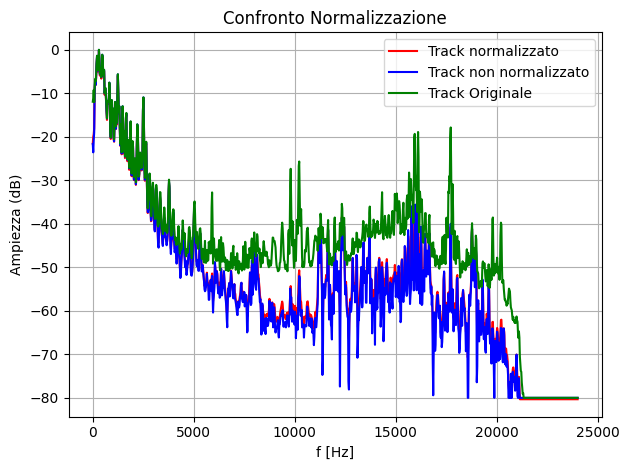

In [ ]:
STFT_norm = lb.stft(track_norm, n_fft = N_FFT, hop_length=HL) # andiamo nel dominio delel frequenze
mod_norm = np.abs(STFT_norm) # calcoliamo il modulo (tempo-frequenza)
norm_profile = np.mean(mod_norm, axis=1) # esegue la media lungo l'asse 1 (tempo), quindi creando un vettore di intensita' (ampiezze)

ref_value = max(np.max(norm_profile), np.max(track_profile), np.max(clean_profile)) # valore per normalizzare le due tracce
norm_db = lb.amplitude_to_db(norm_profile, ref=ref_value)

# Plot confronto 
plt.figure()
plt.plot(f, norm_db, '-r', label='Track normalizzato')
plt.plot(f, w_db, '-b', label='Track non normalizzato')
plt.plot(f, track_db, '-g', label='Track Originale')
plt.xlabel('f [Hz]')
plt.ylabel('Ampiezza (dB)')
plt.title('Confronto Normalizzazione')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

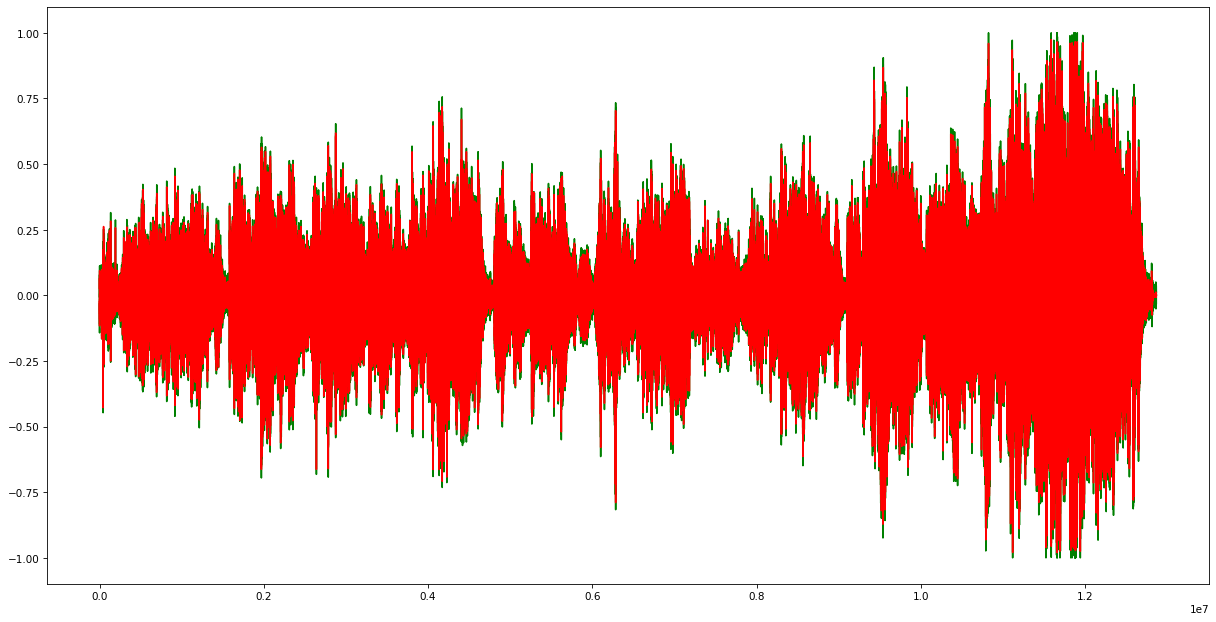

In [ ]:
plt.figure(figsize=(20,10),dpi=75)
plt.plot(music_part, '-g')
plt.plot(track_norm, '-r')

La **STFT** porta con se una serie di *limitazioni*, in primis il compromesso legato al *dominio* stesso della trasformata.

La dimensione della finestra della **STFT**, `N_FFT` e' il parametro che definisce quanti campioni consideriamo per ogni trasformata. Se tale finestra fosse molto ampia avremo una alta risoluzione in termini di frequenze campionate ma una pessima risoluzione temporale, vice versa per una finestra piu' corta. Nel nostro caso questo significa o avere un'ottima riduzione del rumore con perdita della qualita' del brano o piuttosto, come presentato in questo notebook, sempre una alta fedelta' audio con un rumore limitato di sottofondo.

Per nostra fortuna esistono metodologie alternative per la scomposizione del segnale di partenza (permettendoci cosi' di analizzarlo), come presentato nel *paper* qui sotto citato, il dominio ***Wavelet*** ci permette di oltrepassare queste limitazioni e ottenere un segnale, si spera, piu' pulito. 

In particolare, al contrario della ***FFT***, non usa funzioni *trigonometriche* ma piuttosto funzioni omonime (*Wavelet*) che permettono la decomposizione e ricostruzione dei segnali, garantendo la possibilita' di analizzare cambiamenti delle frequenze nel tempo. 
Questa capacita' rende le trasformate ***Wavelet*** ideali per descrivere segnali non stazionari (suono). La Trasformata funziona applicando *iterativamente* filtri *passa alto* e *passa basso* per isolare ed eliminare le componenti rumorose e nel mentre preservare i dettagli piu' fini del segnale. Spesso utilizzato per le immagini puo' esser applicato anche per segnali 1D.


[Wavelet Domain - PDF](../PDF/W.pdf)

Dopo una prima esplorazione del nuovo dominio provo ad applicare una semplice funzione di libreria di ***scipy***, l'output non rispetta il risultato attesto e anche giocando con diversi parametri si ottiene un segnale distorto e rumoroso. (Addirittura peggio di una *Sogliatura*)

Probabilmente perche' tale funzione di libreria risulta fin troppo generica e non valuta correttamente un profilo del rumore.

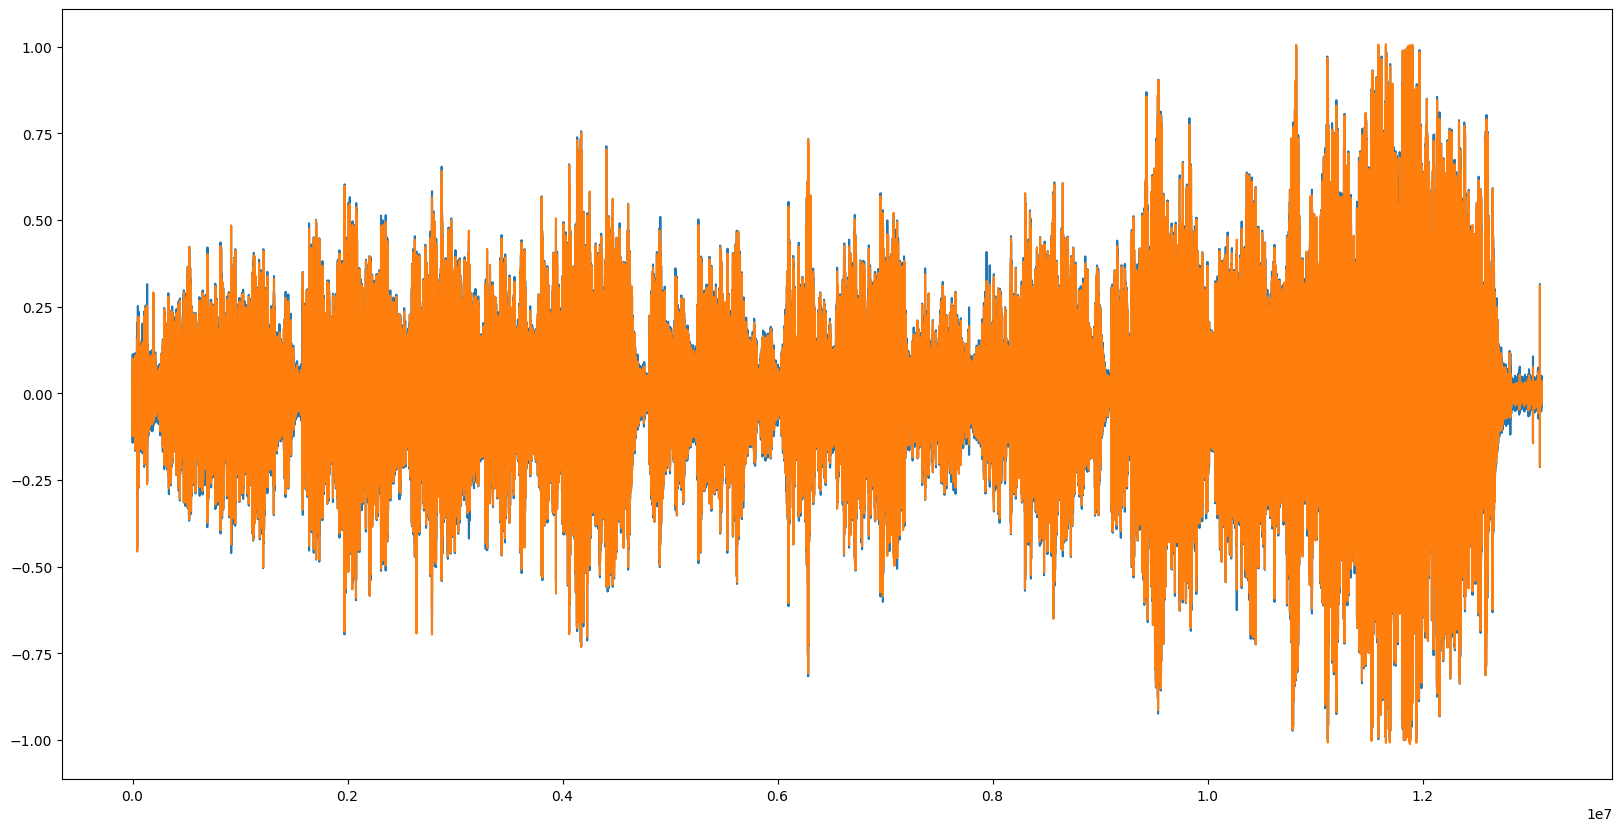

In [ ]:
import pywt
from skimage.restoration import denoise_wavelet

track = track / np.max(np.abs(track)) # Normalizzo la traccia
# Specifico il brano rumoroso, il metodo, che modalita' (soft, hard), quanto a fondo andare, che wavelet scegliere e un bool di rescaling
track_clean = denoise_wavelet(track, method='BayesShrink', mode='soft', wavelet_levels=6, wavelet='sym8', rescale_sigma='True')

# Plotting
plt.figure(figsize=(20,10),dpi=100)
plt.plot(track)
plt.plot(track_clean)

sf.write(OUTPUT_WAVELET, track_norm, sr, subtype='PCM_24') # output

Proviamo ora un approccio piu' dettagliato e complesso